In [1]:
import os, time, random, copy, csv
import numpy as np
from PIL import Image
import pickle

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
import foolbox

In [2]:
from Adversary import AdvDataset, Generate_Adversarial_Samples
from train_sdr import *

In [3]:
from data_helpers import *
from general_helpers import *

# MINIST + 3-layer MLP + SDR (update std w/ gradient)

### Model

In [4]:
hiddens = [28*28, 100, 100, 100]
num_classes = 10
model_sdr_gradient_update = SDR_MLP(hiddens, num_classes)

model_path = os.path.join('saved_models', 'together', 'model_epoch_15_ckpt_test.pt')
model_sdr_gradient_update.load_state_dict(torch.load(model_path))
model_sdr_gradient_update = model_sdr_gradient_update.cuda()
print ('Model is loaded\n')

print('Testing model on regular images...')

trainset, testset, splited = split_MNIST(train_val_split=True, save_path=None)
_, val_loader, _ = load_MNIST(64, trainset, testset, splited, 0)

model_sdr_gradient_update.eval()
_ = validate_stochastic(val_loader, model_sdr_gradient_update, nn.CrossEntropyLoss().cuda())# approx 1% increase


Model is loaded

Testing model on regular images...
Running each sample on the stochastic model for 10 times.
Classification accuracy 95.300


### Use model gradient to generate adversarial samples (FGSM)

In [ ]:
# Run this to generate new samples
method = 'LocalSearch'
adv_samples, adv_tgts = Generate_Adversarial_Samples(model_sdr_gradient_update, val_loader, num_classes, method) #Generate Adv Samples
np.save('adv_samples/val_adv_samples_MINIST_{}.npy'.format(method), adv_samples) #Save the adversarial samples
np.save('adv_samples/val_adv_targets_MINIST_{}.npy'.format(method), adv_tgts) 
print ('Done!')


0


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/foolbox/attacks/base.py:148: UserWarning: LocalSearchAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  ' attack.'.format(self.name()))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'


15


In [ ]:
# Run this if samples have been generated before
adv_samples_gradient = np.load('adv_samples/val_adv_samples_MINIST_LocalSearch.npy')
adv_tgts_gradient = np.load('adv_samples/val_adv_targets_MINIST_LocalSearch.npy')
print(len(adv_tgts_gradient))

In [ ]:
len(val_loader.dataset)

### Test model on adversarial samples

In [ ]:
adv_dataset_gradient = AdvDataset(adv_samples_gradient, adv_tgts_gradient, 10)
adv_dataloader_gradient = DataLoader(adv_dataset_gradient, batch_size = 64, num_workers = 4, drop_last = False)
# _ = validate_regular(adv_dataloader_gradient, model_sdr_gradient_update, nn.CrossEntropyLoss().cuda()) # regular ~ 85%
for x in [1,2,5,10]:
    _ = validate_stochastic(adv_dataloader_gradient, model_sdr_gradient_update, nn.CrossEntropyLoss().cuda(), x)
# single inference (= regular): 85.518
# num_inferences = 2: 90.514
# num_inferences = 5: 93.932 
# num_inferences = 10: 94.923


### Normal vs. Adversarial: example

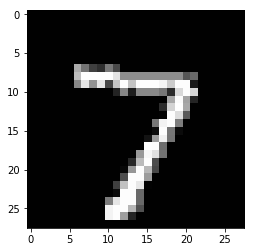

In [11]:
from matplotlib import pyplot as plt
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
valset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
w_original = np.uint8(valset.__getitem__(0)[0]*255)[0]
plt.imshow(w_original, cmap='gray', vmin=0, vmax=255)
plt.show()

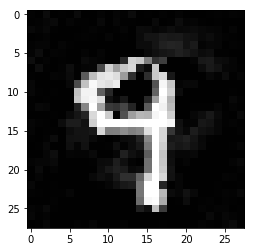

In [21]:
w = np.uint8(adv_samples[6]*255)[0]
plt.imshow(w, cmap='gray', vmin=0, vmax=255)

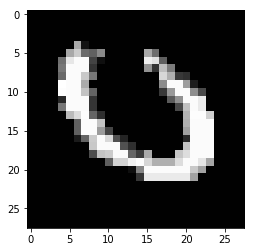

In [16]:
w = np.uint8(val_loader.dataset[1][0]*255)[0]
plt.imshow(w, cmap='gray', vmin=0, vmax=255)

# MINIST + 3-layer MLP - SDR (non-stochastic)

### Model

In [ ]:
hiddens = [28*28, 100, 100, 100]
num_classes = 10
model_regular = MLP(hiddens, num_classes)

model_path = os.path.join('saved_models', 'together', 'model_epoch_15_ckpt_test_regular.pt')
model_regular.load_state_dict(torch.load(model_path))
model_regular = model_regular.cuda()
print ('Model is loaded')

model_regular.eval()
_ = validate_regular(test_loader, model_regular, nn.CrossEntropyLoss().cuda())

### Use model gradient to generate adversarial samples (FGSM)

In [ ]:
# adv_samples_regular, adv_tgts_regular = Generate_Adversarial_Samples(model_regular, test_loader) #Generate Adv Samples
# np.save('val_adv_samples_MINIST_regular.npy', adv_samples_regular) #Save the adversarial samples
# np.save('val_adv_targets_MINIST_regular.npy', adv_tgts_regular) 
# print ('Done!')

In [ ]:
# Run this if samples have been generated before
adv_samples_regular = np.load('val_adv_samples_MINIST_regular.npy')
adv_tgts_regular = np.load('val_adv_targets_MINIST_regular.npy')
print(len(adv_samples_regular))

### Test model on adversarial samples

In [ ]:
adv_dataset_regular = AdvDataset(adv_samples_regular, adv_tgts_regular, 10)
adv_dataloader_regular = DataLoader(adv_dataset_regular, batch_size = 64, num_workers = 4, drop_last = False)
_ = validate(adv_dataloader_regular, model_regular, nn.CrossEntropyLoss().cuda(), 0, 'cuda', 'MINIST')

### Normal vs. Adversarial: example

In [ ]:
w = np.uint8(adv_samples_regular[0]*255)[0]
plt.imshow(w, cmap='gray', vmin=0, vmax=255)

# MINIST + 3-layer MLP + SDR (decay std)

### Model

In [ ]:
hiddens = [28*28, 100, 100, 100]
num_classes = 10
model_sdr_decay_update = MLP(hiddens, num_classes)

model_path = os.path.join('saved_models', 'weight', 'model_epoch_15_ckpt.pt')
model_sdr_decay_update.load_state_dict(torch.load(model_path))
model_sdr_decay_update = model_sdr_decay_update.cuda()
print ('Model is loaded')

model_sdr_decay_update.eval()
stds = np.load(os.path.join('saved_models', 'std','std_epoch_15_ckpt.npy'))
_ = validate_decay(test_loader, model_sdr_decay_update, nn.CrossEntropyLoss().cuda(), stds, 1)
# num_inference = 1: 97.640
# num_inference = 2: 97.650
# num_inference = 5: 97.630
# num_inference = 10: 97.630

### Use model gradient to generate adversarial samples (FGSM)

In [ ]:
adv_samples_decay, adv_tgts_decay = Generate_Adversarial_Samples(model_sdr_decay_update, test_loader) #Generate Adv Samples
np.save('val_adv_samples_MINIST_decay.npy', adv_samples_decay) #Save the adversarial samples
np.save('val_adv_targets_MINIST_decay.npy', adv_tgts_decay) 
print ('Done!')

In [ ]:
adv_samples_decay = np.load('val_adv_samples_MINIST_decay.npy')
adv_tgts_decay = np.load('val_adv_targets_MINIST_decay.npy')

In [ ]:
adv_dataset_decay = AdvDataset(adv_samples_decay, adv_tgts_decay, 10)
adv_dataloader_decay = DataLoader(adv_dataset_decay, batch_size = 64, num_workers = 4, drop_last = False)
_ = validate_decay(adv_dataloader_decay, model_sdr_decay_update, nn.CrossEntropyLoss().cuda(), stds, 10)
# num_inference = 1: 4.508
# num_inference = 2: 3.344
# num_inference = 5: 2.219
# num_inference = 10: 1.506

### Normal vs. Adversarial: example

In [ ]:
w = np.uint8(adv_samples_decay[0]*255)[0]
plt.imshow(w, cmap='gray', vmin=0, vmax=255)